
# AudioEffector Usages

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to use :py:class:`torchaudio.io.AudioEffector` to
apply various effects and codecs to waveform tensor.


<div class="alert alert-info"><h4>Note</h4><p>This tutorial requires FFmpeg libraries.
   Please refer to `FFmpeg dependency <ffmpeg_dependency>` for
   the detail.</p></div>




## Overview

:py:class:`~torchaudio.io.AudioEffector` combines in-memory encoding,
decoding and filtering that are provided by
:py:class:`~torchaudio.io.StreamWriter` and
:py:class:`~torchaudio.io.StreamReader`.

The following figure illustrates the process.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/AudioEffector.png">




In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.1.0+cu118
2.1.0+cu118


In [2]:
from torchaudio.io import AudioEffector, CodecConfig

import matplotlib.pyplot as plt
from IPython.display import Audio

In [3]:
for k, v in torchaudio.utils.ffmpeg_utils.get_versions().items():
    print(k, v)

libavcodec (58, 134, 100)
libavdevice (58, 13, 100)
libavfilter (7, 110, 100)
libavformat (58, 76, 100)
libavutil (56, 70, 100)


## Usage

To use ``AudioEffector``, instantiate it with ``effect`` and
``format``, then either pass the waveform to
:py:meth:`~torchaudio.io.AudioEffector.apply` or
:py:meth:`~torchaudio.io.AudioEffector.stream` method.

.. code:: python

   effector = AudioEffector(effect=..., format=...,)

   # Apply at once
   applied = effector.apply(waveform, sample_rate)

``apply`` method applies effect and codec to the entire waveform at
once. So if the input waveform is long, and memory consumption is an
issue, one can use ``stream`` method to process chunk by chunk.

.. code:: python

   # Apply chunk by chunk
   for applied_chunk = effector.stream(waveform, sample_rate):
       ...




## Example




In [4]:
src = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
waveform, sr = torchaudio.load(src, channels_first=False)

100%|██████████| 106k/106k [00:00<00:00, 9.49MB/s]


## Gallery




In [5]:
def show(effect, *, stereo=False):
    wf = torch.cat([waveform] * 2, dim=1) if stereo else waveform
    figsize = (6.4, 2.1 if stereo else 1.2)

    effector = AudioEffector(effect=effect, pad_end=False)
    result = effector.apply(wf, int(sr))

    num_channels = result.size(1)
    f, ax = plt.subplots(num_channels, 1, squeeze=False, figsize=figsize, sharex=True)
    for i in range(num_channels):
        ax[i][0].specgram(result[:, i], Fs=sr)
    f.set_tight_layout(True)

    return Audio(result.numpy().T, rate=sr)

## Original




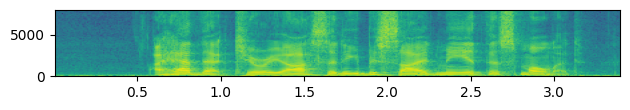

In [6]:
show(effect=None)

## Effects




### tempo
https://ffmpeg.org/ffmpeg-filters.html#atempo



In [ ]:
show("atempo=0.7")

In [ ]:
show("atempo=1.8")

### highpass
https://ffmpeg.org/ffmpeg-filters.html#highpass



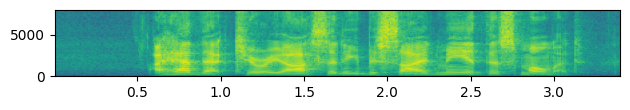

In [7]:
show("highpass=frequency=1500")

### lowpass
https://ffmpeg.org/ffmpeg-filters.html#lowpass



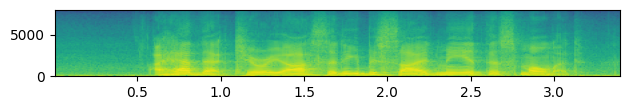

In [8]:
show("lowpass=frequency=1000")

### allpass
https://ffmpeg.org/ffmpeg-filters.html#allpass



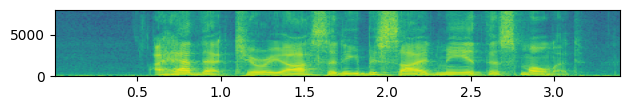

In [9]:
show("allpass")

### bandpass
https://ffmpeg.org/ffmpeg-filters.html#bandpass



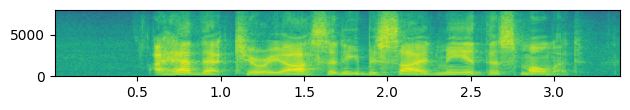

In [10]:
show("bandpass=frequency=3000")

### bandreject
https://ffmpeg.org/ffmpeg-filters.html#bandreject



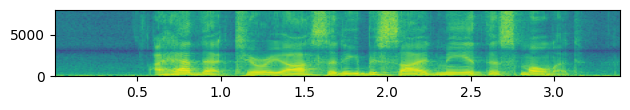

In [11]:
show("bandreject=frequency=3000")

### echo
https://ffmpeg.org/ffmpeg-filters.html#aecho



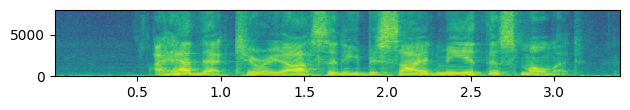

In [12]:
show("aecho=in_gain=0.8:out_gain=0.88:delays=6:decays=0.4")

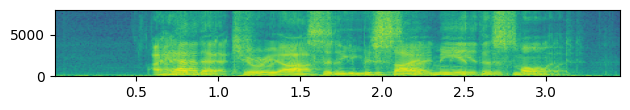

In [13]:
show("aecho=in_gain=0.8:out_gain=0.88:delays=60:decays=0.4")

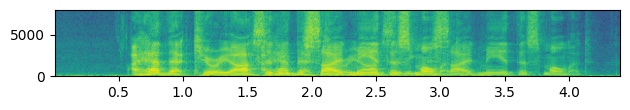

In [14]:
show("aecho=in_gain=0.8:out_gain=0.9:delays=1000:decays=0.3")

### chorus
https://ffmpeg.org/ffmpeg-filters.html#chorus



/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


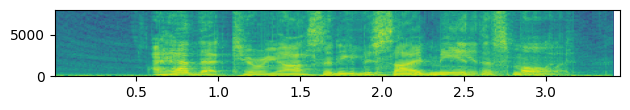

In [15]:
show("chorus=0.5:0.9:50|60|40:0.4|0.32|0.3:0.25|0.4|0.3:2|2.3|1.3")

### fft filter
https://ffmpeg.org/ffmpeg-filters.html#afftfilt



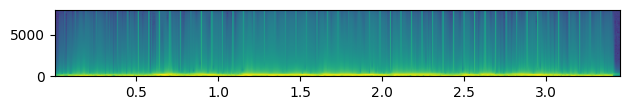

In [16]:
# fmt: off
show(
    "afftfilt="
    "real='re * (1-clip(b * (b/nb), 0, 1))':"
    "imag='im * (1-clip(b * (b/nb), 0, 1))'"
)

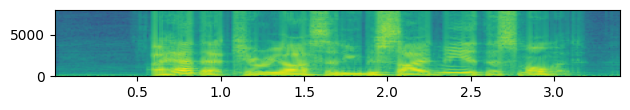

In [17]:
show(
    "afftfilt="
    "real='hypot(re,im) * sin(0)':"
    "imag='hypot(re,im) * cos(0)':"
    "win_size=512:"
    "overlap=0.75"
)

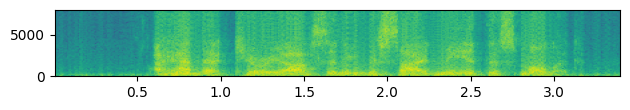

In [18]:
show(
    "afftfilt="
    "real='hypot(re,im) * cos(2 * 3.14 * (random(0) * 2-1))':"
    "imag='hypot(re,im) * sin(2 * 3.14 * (random(1) * 2-1))':"
    "win_size=128:"
    "overlap=0.8"
)
# fmt: on

### vibrato
https://ffmpeg.org/ffmpeg-filters.html#vibrato



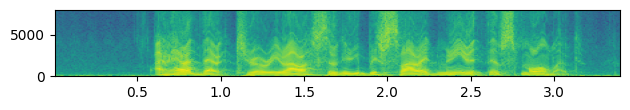

In [19]:
show("vibrato=f=10:d=0.8")

### tremolo
https://ffmpeg.org/ffmpeg-filters.html#tremolo



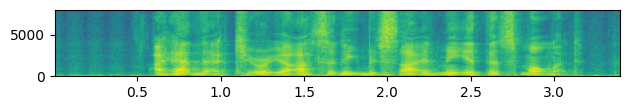

In [20]:
show("tremolo=f=8:d=0.8")

### crystalizer
https://ffmpeg.org/ffmpeg-filters.html#crystalizer



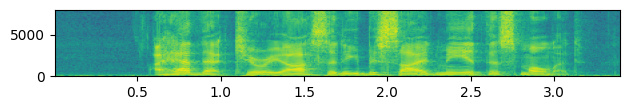

In [21]:
show("crystalizer")

### flanger
https://ffmpeg.org/ffmpeg-filters.html#flanger



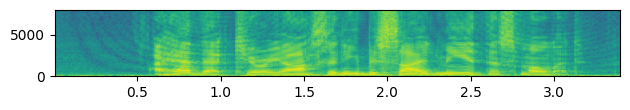

In [22]:
show("flanger")

### phaser
https://ffmpeg.org/ffmpeg-filters.html#aphaser



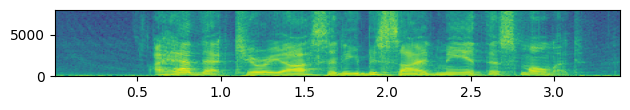

In [23]:
show("aphaser")

### pulsator
https://ffmpeg.org/ffmpeg-filters.html#apulsator



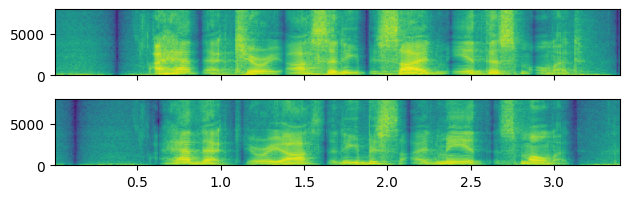

In [24]:
show("apulsator", stereo=True)

### haas
https://ffmpeg.org/ffmpeg-filters.html#haas



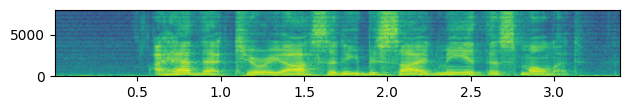

In [25]:
show("haas")

## Codecs




In [26]:
def show_multi(configs):
    results = []
    for config in configs:
        effector = AudioEffector(**config)
        results.append(effector.apply(waveform, int(sr)))

    num_configs = len(configs)
    figsize = (6.4, 0.3 + num_configs * 0.9)
    f, axes = plt.subplots(num_configs, 1, figsize=figsize, sharex=True)
    for result, ax in zip(results, axes):
        ax.specgram(result[:, 0], Fs=sr)
    f.set_tight_layout(True)

    return [Audio(r.numpy().T, rate=sr) for r in results]

### ogg




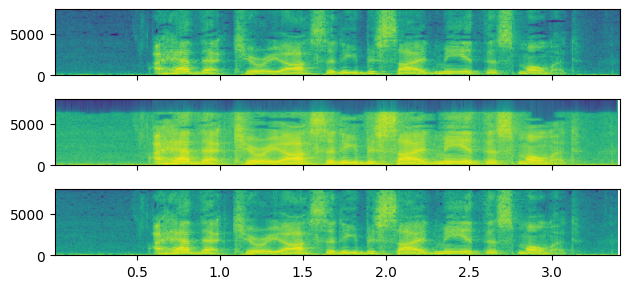

In [27]:
results = show_multi(
    [
        {"format": "ogg"},
        {"format": "ogg", "encoder": "vorbis"},
        {"format": "ogg", "encoder": "opus"},
    ]
)

#### ogg - default encoder (flac)




In [28]:
results[0]

#### ogg - vorbis




In [29]:
results[1]

#### ogg - opus




In [30]:
results[2]

### mp3
https://trac.ffmpeg.org/wiki/Encode/MP3



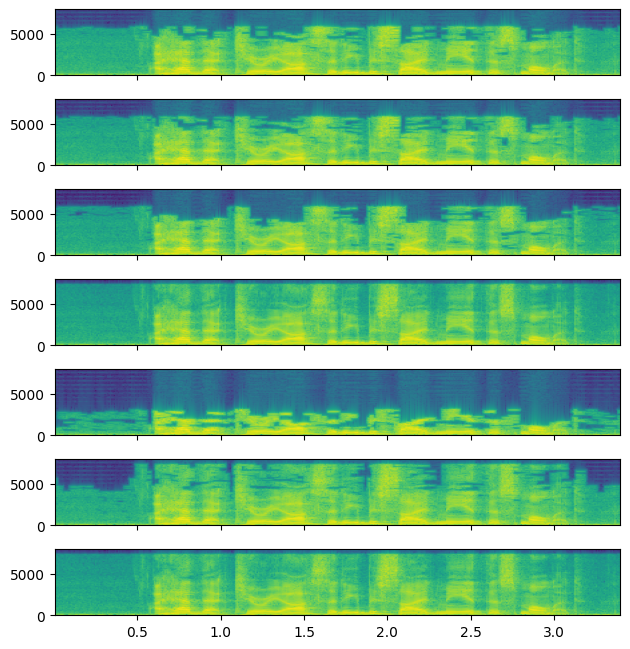

In [31]:
results = show_multi(
    [
        {"format": "mp3"},
        {"format": "mp3", "codec_config": CodecConfig(compression_level=1)},
        {"format": "mp3", "codec_config": CodecConfig(compression_level=9)},
        {"format": "mp3", "codec_config": CodecConfig(bit_rate=192_000)},
        {"format": "mp3", "codec_config": CodecConfig(bit_rate=8_000)},
        {"format": "mp3", "codec_config": CodecConfig(qscale=9)},
        {"format": "mp3", "codec_config": CodecConfig(qscale=1)},
    ]
)

#### default



In [32]:
results[0]

#### compression_level=1



In [33]:
results[1]

#### compression_level=9



In [34]:
results[2]

#### bit_rate=192k



In [35]:
results[3]

#### bit_rate=8k



In [36]:
results[4]

#### qscale=9



In [37]:
results[5]

#### qscale=1



In [38]:
results[6]

Tag: :obj:`torchaudio.io`

